# Description
Notebook to compare the redshift power spectrum deduced from the data to Kaiser's linear theory. The chosen cosmology, BoxSize, LOS, redshift is the same as those used in the generation of the mock data (see header of file or README in data directory). The linear bias is left as a free parameter and later fixed such that $\chi^2$ between data and linear theory is minimal.

Since data file is large, keep it in a separate directory.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import cat_power_algos as catpk

from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
filename = '/home/jwack/power_mockdata/HMQELG-eBOSS-density.gcat' 

cosmo = cosmology.Planck15
BoxSize = 1000
LOS = [1,0,0]
redshift = 0

Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

In [4]:
Nmesh = 256
k_Nyq = np.pi*Nmesh/BoxSize
k_min = 0.005
k_max = k_Nyq*1.05 # FFTPower only computes upto k_Nyq 
#Nk = 200 
delta_k = 0.00687050087737447 # 30 bins for Nmesh=64
Nk = int((k_max - k_min)/delta_k) # number of bins

kbin = [k_min,k_max,Nk,'lin']

In [5]:
def kaiser_pkmu(k, mu, b1):
    """Returns power spectrum in redshift space, following Kaiser's linear results."""
    beta = cosmo.scale_independent_growth_rate(redshift) / b1 
    return (1 + beta*mu**2)**2 *b1**2 * Plin(k)


def chi2(b1, k, pk_data, mu):
    '''Find chi^2 for fixed mu.'''
    std2 = np.ones(pk_data.shape)
    return np.sum((pk_data - kaiser_pkmu(k,mu,b1))**2 / std2)

In [22]:
cat = catpk.make_cat(filename, cosmo=cosmo, LOS=LOS, z=redshift)
kmaxs, b1_fits, chi2_mins = [], [], []

Nk = 200 # number of k bins
k_min = 0.005

for k_max in np.linspace(0.05, 2, 5):
    t1 = time.time()
    Nmesh = int(BoxSize/np.pi*k_max)
    kbin = [k_min,k_max,Nk,'lin']
    
    mesh = cat.to_mesh(position='RSDPosition', resampler='tsc', BoxSize=BoxSize, Nmesh=Nmesh, compensated=True)
    mu = 1
    r = FFTPower(mesh, mode='1d', dk=0.005, kmin=k_min).power
    s = minimize(chi2, 1, args=(r['k'], r['power'].real - r.attrs['shotnoise'], mu))
    #k, Pk = catpk.get_binned_Pk(mesh, kbin)
    #s = minimize(chi2, 1, args=(k, Pk, mu))
    
    kmaxs.append(k_max)
    b1_fits.append(s.x[0])
    chi2_mins.append(s.fun)
    t2 = time.time()
    print("Finished kmax={:.3f} in t={:.2f} seconds".format(k_max, t2-t1))

Loading /home/jwack/power_mockdata/HMQELG-eBOSS-density.gcat
Finished kmax=0.050 in t=0.38 seconds
Finished kmax=0.537 in t=0.72 seconds
Finished kmax=1.025 in t=3.92 seconds
Finished kmax=1.512 in t=10.17 seconds
Finished kmax=2.000 in t=21.49 seconds


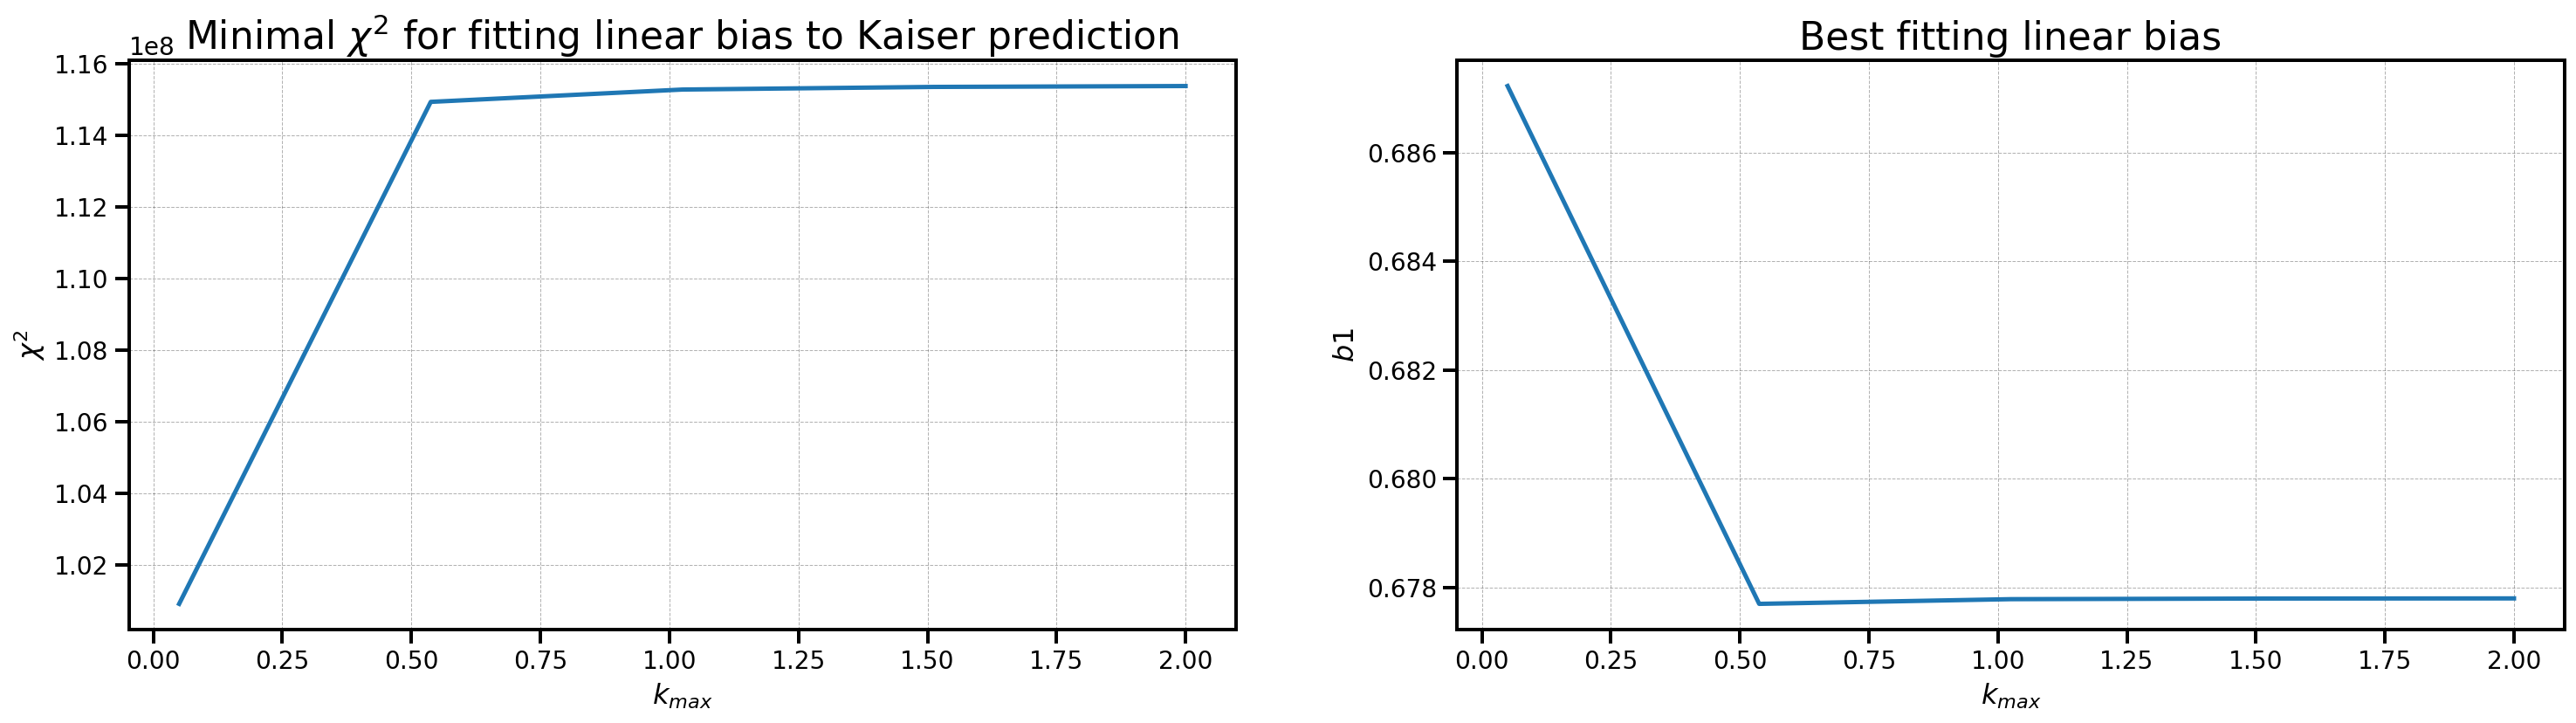

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,6))

ax1.plot(kmaxs, chi2_mins)
ax1.set_title('Minimal $\chi^2$ for fitting linear bias to Kaiser prediction')
ax1.set_xlabel('$k_{max}$')
ax1.set_ylabel('$\chi^2$')

ax2.plot(kmaxs, b1_fits)
ax2.set_title('Best fitting linear bias')
ax2.set_xlabel('$k_{max}$')
ax2.set_ylabel('$b1$')

plt.show()
fname = 'plots/chi2_minimization.pdf'
#fig.savefig(fname)

The larger `Nmesh`, the greater `kmax` and thus the further we enter the non-linear regime. Thus we expect the difference between data and linear theory to grow such that $\chi^2$ becomes large. 

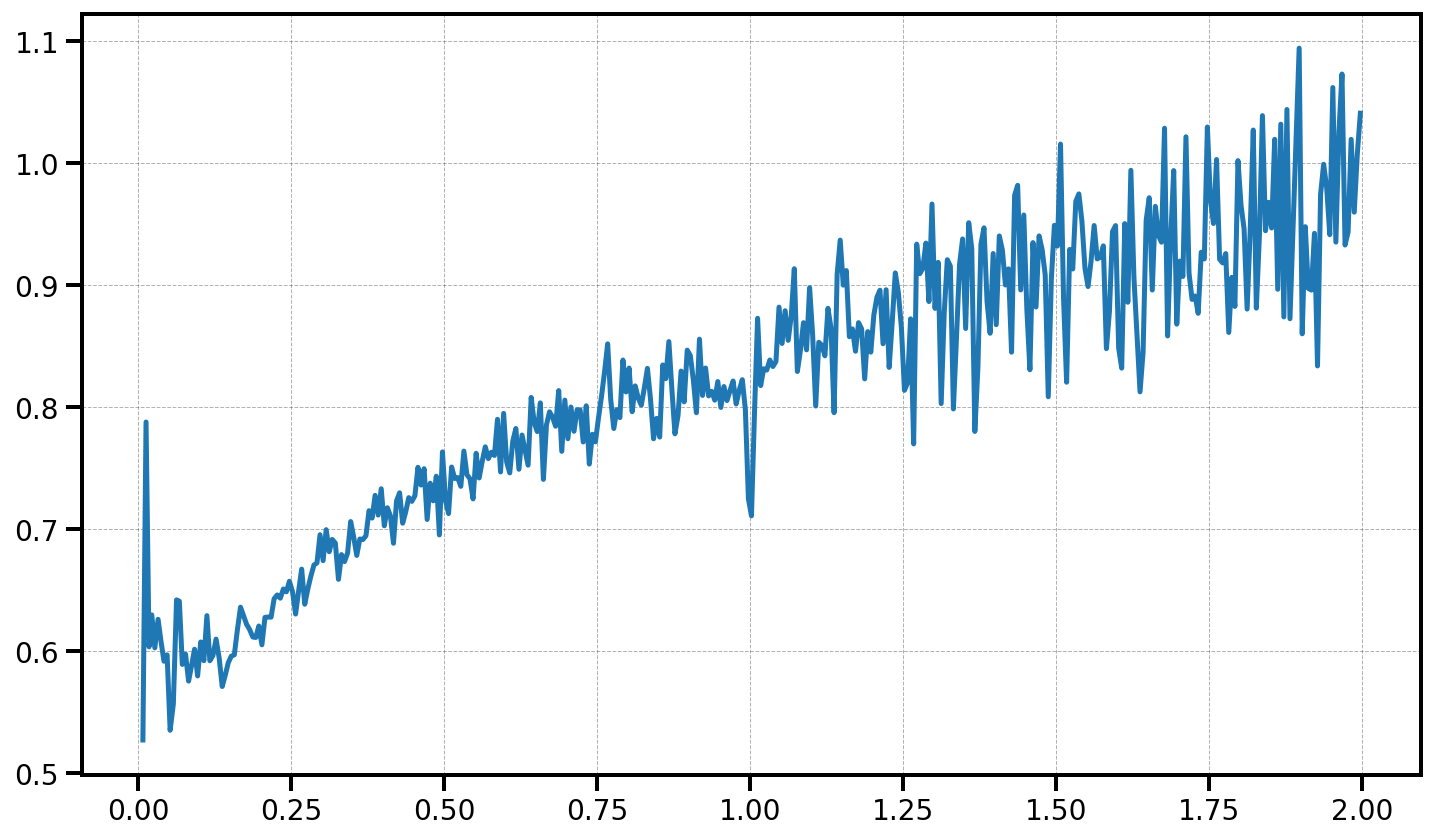

In [25]:
plt.plot(r['k'], (r['power'].real - r.attrs['shotnoise'])/kaiser_pkmu(r['k'],1,1))

In [17]:
Nmesh

636